## Import libraries

In [43]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.stats import poisson, nbinom

## Load data - exports

In [44]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

In [45]:
df = pd.read_csv(data_path / 'dati_leo_assoluti.csv')
df = df.reset_index(drop=True)

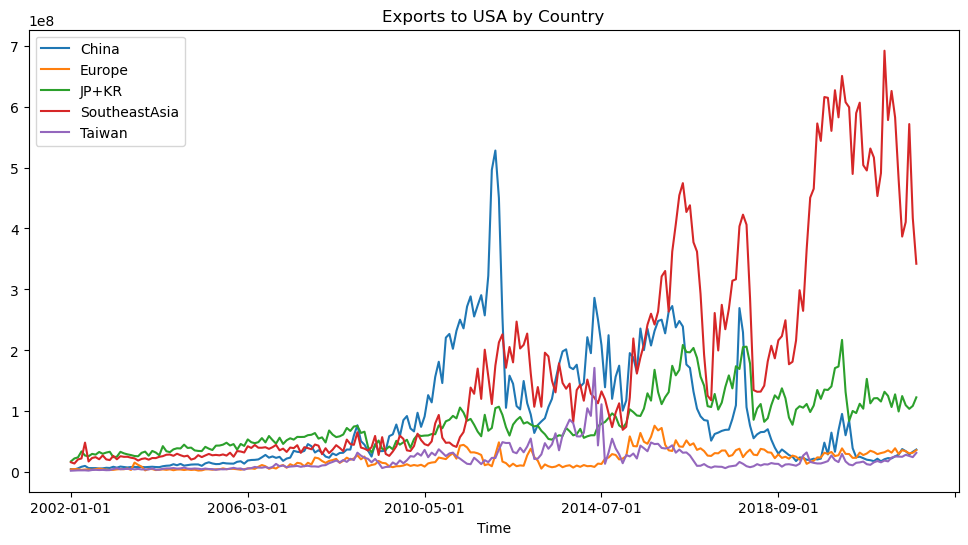

In [46]:
df.set_index('Time').plot(figsize=(12, 6), title='Exports to USA by Country')
plt.show()

## Model 1 - tariffs as a dummy variable

### Model

In [28]:
# Uncomment if you want normalized values
df_normalized = pd.read_csv(data_path / 'dati_leo_normalizzati.csv')
df_normalized = df_normalized.reset_index(drop=True)
df_normalized = df_normalized.drop(columns=['Europe', 'total'])
df_normalized

# # Uncomment if you want absolute values
# df_normalized = df.copy()
# df_normalized = df_normalized.drop(columns=['Europe'])
# df_normalized

,Time,China,JP+KR,SoutheastAsia,Taiwan
0,2002-01-01,0.110311,0.380993,0.352239,0.054684
1,2002-02-01,0.093534,0.454315,0.287546,0.057884
2,2002-03-01,0.107718,0.406185,0.349512,0.052608
3,2002-04-01,0.123506,0.467669,0.310324,0.044436
4,2002-05-01,0.110933,0.290828,0.515878,0.033958
...,...,...,...,...,...
235,2021-08-01,0.062298,0.204443,0.632360,0.041596
236,2021-09-01,0.055998,0.177974,0.663774,0.046366
237,2021-10-01,0.038418,0.136539,0.749306,0.035138
238,2021-11-01,0.054520,0.176605,0.676466,0.040333


In [29]:
df_tariffs = pd.DataFrame()
df_tariffs['Time'] = df_normalized['Time']
df_tariffs

,Time
0,2002-01-01
1,2002-02-01
2,2002-03-01
3,2002-04-01
4,2002-05-01
...,...
235,2021-08-01
236,2021-09-01
237,2021-10-01
238,2021-11-01


In [30]:
df_tariffs['China Tariff'] = np.where(df_tariffs['Time'] < '2012-05-01', 0, 1)
df_tariffs['JP+KR Tariff'] = np.where(df_tariffs['Time'] < '2018-02-01', 0, 1)
df_tariffs['SoutheastAsia Tariff'] = np.where(df_tariffs['Time'] < '2018-02-01', 0, 1)
df_tariffs['Taiwan Tariff'] = np.where(df_tariffs['Time'] < '2014-12-01', 0, 1)
df_tariffs

,Time,China Tariff,JP+KR Tariff,SoutheastAsia Tariff,Taiwan Tariff
0,2002-01-01,0,0,0,0
1,2002-02-01,0,0,0,0
2,2002-03-01,0,0,0,0
3,2002-04-01,0,0,0,0
4,2002-05-01,0,0,0,0
...,...,...,...,...,...
235,2021-08-01,1,1,1,1
236,2021-09-01,1,1,1,1
237,2021-10-01,1,1,1,1
238,2021-11-01,1,1,1,1


In [31]:
def lotka_volterra_with_tariffs_bin(t, X, tariffs,
                                r1, r2, r3, r4,
                                a11, a12, a13, a14,
                                a21, a22, a23, a24,
                                a31, a32, a33, a34,
                                a41, a42, a43, a44,
                                b11, b12, b13, b14,
                                b21, b22, b23, b24,
                                b31, b32, b33, b34,
                                b41, b42, b43, b44):
    X1, X2, X3, X4 = X
    tariff_1, tariff_2, tariff_3, tariff_4 = tariffs.iloc[int(t), 1:]

    dx1dt = r1 * X1 * (1 - a11*X1 - a12*X2 - a13*X3 - a14*X4) - b11 * X2 * X3 * X4 * tariff_1 + b12 * X2 * tariff_2 + b13 * X3 * tariff_3 + b14 * X4 * tariff_4
    dx2dt = r2 * X2 * (1 - a21*X1 - a22*X2 - a23*X3 - a24*X4) + b21 * X1 * tariff_1 - b22 * X1 * X3 * X4 * tariff_2 + b23 * X3 * tariff_3 + b24 * X4 * tariff_4
    dx3dt = r3 * X3 * (1 - a31*X1 - a32*X2 - a33*X3 - a34*X4) + b31 * X1 * tariff_1 + b32 * X2 * tariff_2 - b33 * X1 * X2 * X4 * tariff_3 + b34 * X4 * tariff_4
    dx4dt = r4 * X4 * (1 - a41*X1 - a42*X2 - a43*X3 - a44*X4) + b41 * X1 * tariff_1 + b42 * X2 * tariff_2 + b43 * X3 * tariff_3 - b44 * X1 * X2 * X3 * tariff_4

    return [dx1dt, dx2dt, dx3dt, dx4dt]

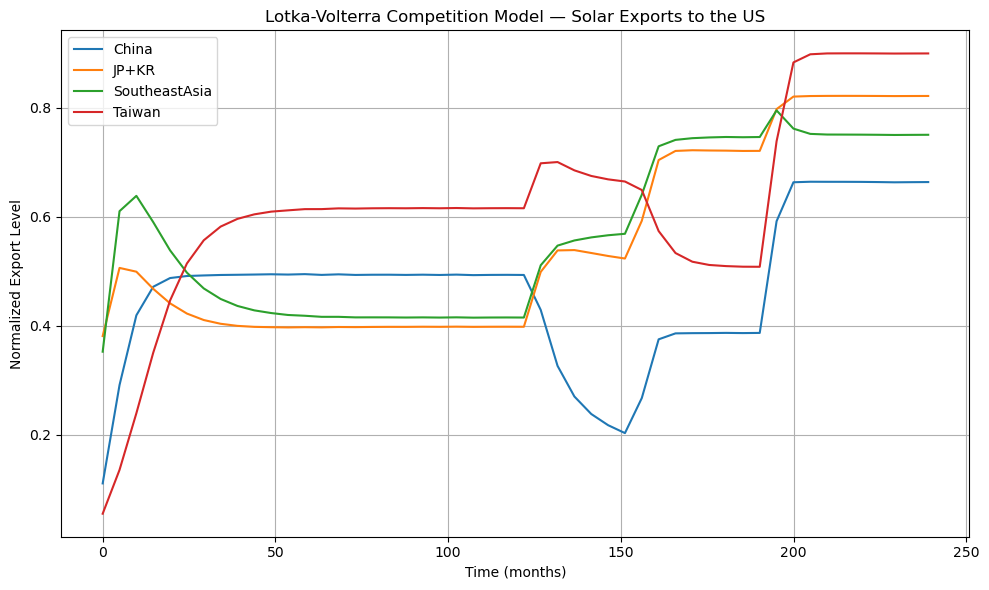

In [32]:
# Uncomment to use parameters for normalized values
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.35,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.5,
    'a41': 0.2, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0,
    'b11': 0.1, 'b12': 0.1, 'b13': 0.1, 'b14': 0.1,
    'b21': 0.1, 'b22': 0.1, 'b23': 0.1, 'b24': 0.1,
    'b31': 0.1, 'b32': 0.1, 'b33': 0.1, 'b34': 0.1,
    'b41': 0.1, 'b42': 0.1, 'b43': 0.1, 'b44': 0.1
}

# # Uncomment to use parameters for absolute values
# params = {
#     'r1': 50.0, 'r2': 30.0, 'r3': 40.0, 'r4': 35.0,
#     'a11': 0.00001, 'a12': 0.000006, 'a13': 0.000004, 'a14': 0.000003,
#     'a21': 0.000004, 'a22': 0.000002, 'a23': 0.000003, 'a24': 0.000004,
#     'a31': 0.000004, 'a32': 0.000002, 'a33': 0.000003, 'a34': 0.000005,
#     'a41': 0.000006, 'a42': 0.000004, 'a43': 0.000004, 'a44': 0.00001,
#     'b11': 0.000001, 'b21': 0.000001, 'b31': 0.000001, 'b41': 0.000001,
#     'b12': 0.000001, 'b22': 0.000001, 'b32': 0.000001, 'b42': 0.000001,
#     'b13': 0.000001, 'b23': 0.000001, 'b33': 0.000001, 'b43': 0.000001,
#     'b14': 0.000001, 'b24': 0.000001, 'b34': 0.000001, 'b44': 0.000001
# }


# Initial conditions (example, adjust as needed)
X0 = df_normalized.iloc[0, 1:].values.tolist()  # Use the first row of normalized data as initial conditions

# Time span and evaluation points
t_span = (0, 239)
t_eval = np.linspace(*t_span)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_bin(t, X, df_tariffs, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='JP+KR')
plt.plot(sol.t, sol.y[2], label='SoutheastAsia')
plt.plot(sol.t, sol.y[3], label='Taiwan')
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model Calibration - Least Squares

In [33]:
china_data = df_normalized['China']
jpkr_data = df_normalized['JP+KR']
southeastasia_data = df_normalized['SoutheastAsia']
taiwan_data = df_normalized['Taiwan']

# Stack data for comparison
data = np.vstack([china_data, jpkr_data, southeastasia_data, taiwan_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [34]:
def residuals(params, X0, tariffs, t_data, data):
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:20]
    b11, b12, b13, b14 = params[20:24]
    b21, b22, b23, b24 = params[24:28]
    b31, b32, b33, b34 = params[28:32]
    b41, b42, b43, b44 = params[32:36]

    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_with_tariffs_bin(
            t, X, tariffs, r1, r2, r3, r4,
            a11, a12, a13, a14,
            a21, a22, a23, a24,
            a31, a32, a33, a34,
            a41, a42, a43, a44,
            b11, b12, b13, b14,
            b21, b22, b23, b24,
            b31, b32, b33, b34,
            b41, b42, b43, b44
        ),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data
    )

    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    return (sol.y - data).ravel()

In [35]:
# Initial guess for 4 regions: r1, r2, r3, r4, a11, a12, a13, a14, ..., b44 (total 36 params)
initial_guess = [
    params['r1'], params['r2'], params['r3'], params['r4'],
    params['a11'], params['a12'], params['a13'], params['a14'],
    params['a21'], params['a22'], params['a23'], params['a24'],
    params['a31'], params['a32'], params['a33'], params['a34'],
    params['a41'], params['a42'], params['a43'], params['a44'],
    params['b11'], params['b12'], params['b13'], params['b14'],
    params['b21'], params['b22'], params['b23'], params['b24'],
    params['b31'], params['b32'], params['b33'], params['b34'],
    params['b41'], params['b42'], params['b43'], params['b44']
]

In [36]:
# Initial export levels from your data
X0 = data[:, 0]

# Fit the model
result = least_squares(residuals, initial_guess, args=(X0, df_tariffs, t_data, data), bounds=(0, np.inf))  # constrain params to be positive

# Extract best-fit parameters
fitted_params = result.x

In [37]:
fitted_params

array([5.02526638e-01, 8.93816659e-01, 3.90661762e-01, 1.01697020e+00,
       1.15895888e+00, 2.74535558e-01, 2.06431155e+00, 1.90252573e-01,
       2.48798187e-01, 1.39699489e+00, 1.30332458e+00, 1.71250443e+00,
       6.58153024e-01, 3.78377311e-01, 2.12586097e+00, 1.64760795e+00,
       3.48877660e-01, 9.32130665e-01, 1.71528841e+00, 1.61903742e+00,
       2.64156172e-01, 2.44760952e-02, 4.46426027e-03, 2.17131057e-01,
       1.80076150e-03, 2.97166509e-01, 6.21536717e-02, 2.24099310e-02,
       7.31252574e-02, 7.44672121e-01, 9.11584214e-02, 1.26898057e-01,
       3.65168622e-02, 3.91735025e-02, 1.61597055e-02, 4.58407910e-01])

In [38]:
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_bin(t, X, df_tariffs, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

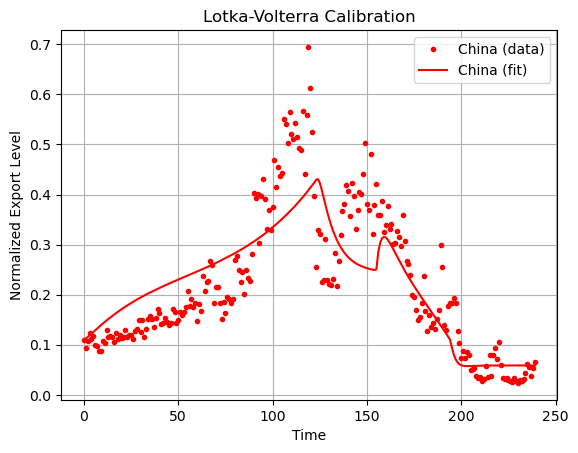

In [39]:
# Plot
plt.plot(t_data[:len(data[0])], data[0], 'r.', label='China (data)')
plt.plot(t_data, sol.y[0], 'r-', label='China (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

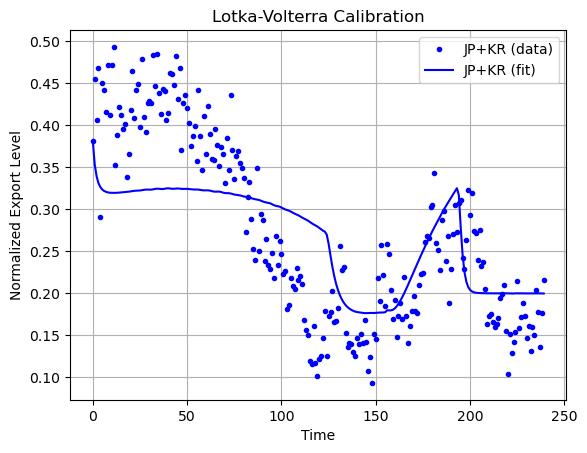

In [40]:
plt.plot(t_data[:len(data[1])], data[1], 'b.', label='JP+KR (data)')
plt.plot(t_data, sol.y[1], 'b-', label='JP+KR (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

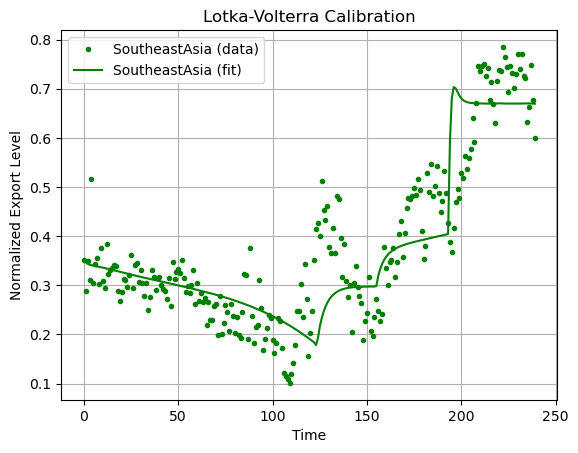

In [41]:
plt.plot(t_data[:len(data[2])], data[2], 'g.', label='SoutheastAsia (data)')
plt.plot(t_data, sol.y[2], 'g-', label='SoutheastAsia (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

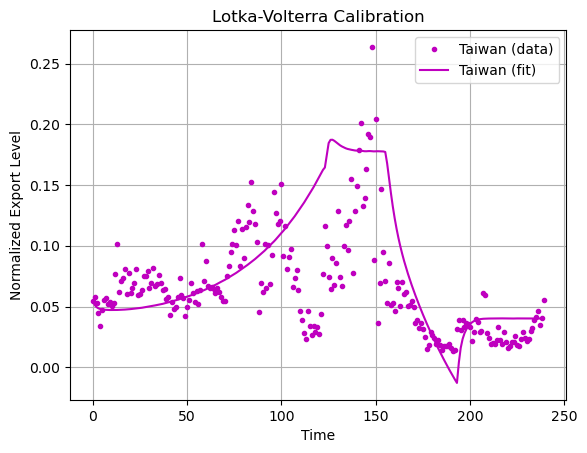

In [42]:
plt.plot(t_data[:len(data[3])], data[3], 'm.', label='Taiwan (data)')
plt.plot(t_data, sol.y[3], 'm-', label='Taiwan (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

### Prediction

In [51]:
df_tariffs_pred = pd.concat([df_tariffs.copy(), pd.DataFrame(np.zeros([240, 4]), columns=['China Tariff', 'JP+KR Tariff', 'SoutheastAsia Tariff', 'Taiwan Tariff'])], axis=0)
df_tariffs_pred = df_tariffs_pred.reset_index(drop=True)
df_tariffs_pred['Time'] = pd.date_range(start='2002-01-01', periods=len(df_tariffs_pred), freq='MS')
df_tariffs_pred

,Time,China Tariff,JP+KR Tariff,SoutheastAsia Tariff,Taiwan Tariff
0,2002-01-01,0.0,0.0,0.0,0.0
1,2002-02-01,0.0,0.0,0.0,0.0
2,2002-03-01,0.0,0.0,0.0,0.0
3,2002-04-01,0.0,0.0,0.0,0.0
4,2002-05-01,0.0,0.0,0.0,0.0
...,...,...,...,...,...
475,2041-08-01,0.0,0.0,0.0,0.0
476,2041-09-01,0.0,0.0,0.0,0.0
477,2041-10-01,0.0,0.0,0.0,0.0
478,2041-11-01,0.0,0.0,0.0,0.0


In [ ]:
df_tariffs_pred['China Tariff'] = np.where(df_tariffs_pred['Time'] < '2026-05-01', 0, 1)
df_tariffs_pred['JP+KR Tariff'] = np.where(df_tariffs_pred['Time'] < '2028-02-01', 0, 1)
df_tariffs_pred['SoutheastAsia Tariff'] = np.where(df_tariffs_pred['Time'] < '2023-02-01', 0, 1)
df_tariffs_pred['Taiwan Tariff'] = np.where(df_tariffs_pred['Time'] < '2025-12-01', 0, 1)
df_tariffs_pred

,Time,China Tariff,JP+KR Tariff,SoutheastAsia Tariff,Taiwan Tariff
0,2002-01-01,0,0,0,0
1,2002-02-01,0,0,0,0
2,2002-03-01,0,0,0,0
3,2002-04-01,0,0,0,0
4,2002-05-01,0,0,0,0
...,...,...,...,...,...
475,2041-08-01,1,1,1,1
476,2041-09-01,1,1,1,1
477,2041-10-01,1,1,1,1
478,2041-11-01,1,1,1,1


In [ ]:
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_bin(t, X, df_tariffs_pred, *fitted_params),
    t_span=(0, len(df_tariffs_pred) - 1),
    y0=X0,
    t_eval=np.arange(len(df_tariffs_pred))
)

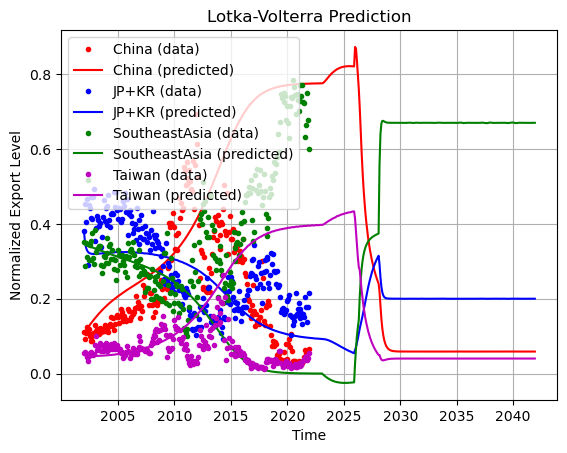

In [50]:
# Plot
plt.plot(df_tariffs_pred['Time'][:len(data[0])], data[0], 'r.', label='China (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[0], 'r-', label='China (predicted)')
plt.plot(df_tariffs_pred['Time'][:len(data[1])], data[1], 'b.', label='JP+KR (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[1], 'b-', label='JP+KR (predicted)')
plt.plot(df_tariffs_pred['Time'][:len(data[2])], data[2], 'g.', label='SoutheastAsia (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[2], 'g-', label='SoutheastAsia (predicted)')
plt.plot(df_tariffs_pred['Time'][:len(data[3])], data[3], 'm.', label='Taiwan (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[3], 'm-', label='Taiwan (predicted)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Prediction')
plt.grid(True)
plt.show()

## Model 2 - tariffs with true values

### Model

In [63]:
# Uncomment if you want normalized values
df_normalized = pd.read_csv(data_path / 'dati_leo_normalizzati.csv')
df_normalized = df_normalized.reset_index(drop=True)
df_normalized = df_normalized.drop(columns=['Europe', 'total'])
df_normalized

# # Uncomment if you want absolute values
# df_normalized = df.copy()
# df_normalized = df_normalized.drop(columns=['Europe'])
# df_normalized

,Time,China,JP+KR,SoutheastAsia,Taiwan
0,2002-01-01,0.110311,0.380993,0.352239,0.054684
1,2002-02-01,0.093534,0.454315,0.287546,0.057884
2,2002-03-01,0.107718,0.406185,0.349512,0.052608
3,2002-04-01,0.123506,0.467669,0.310324,0.044436
4,2002-05-01,0.110933,0.290828,0.515878,0.033958
...,...,...,...,...,...
235,2021-08-01,0.062298,0.204443,0.632360,0.041596
236,2021-09-01,0.055998,0.177974,0.663774,0.046366
237,2021-10-01,0.038418,0.136539,0.749306,0.035138
238,2021-11-01,0.054520,0.176605,0.676466,0.040333


In [64]:
df_tariffs = pd.read_csv(data_path / 'tariffs_final.csv')
df_tariffs

,Time,China Tariff,JP+KR Tariff,SoutheastAsia Tariff,Taiwan Tariff
0,2002-01-01,0.00,0.00,0.00,0.00
1,2002-02-01,0.00,0.00,0.00,0.00
2,2002-03-01,0.00,0.00,0.00,0.00
3,2002-04-01,0.00,0.00,0.00,0.00
4,2002-05-01,0.00,0.00,0.00,0.00
...,...,...,...,...,...
235,2021-08-01,0.15,0.15,0.15,0.15
236,2021-09-01,0.15,0.15,0.15,0.15
237,2021-10-01,0.15,0.15,0.15,0.15
238,2021-11-01,0.15,0.15,0.15,0.15


In [77]:
def lotka_volterra_with_tariffs_end(t, X, tariffs,
    r1, r2, r3, r4,
    a11, a12, a13, a14,
    a21, a22, a23, a24,
    a31, a32, a33, a34,
    a41, a42, a43, a44,
    b12, b13, b14,  # penalty on 1 when disadvantaged vs 2,3,4
    b21, b23, b24,  # penalty on 2 when disadvantaged vs 1,3,4
    b31, b32, b34,  # ...
    b41, b42, b43   # ...
):
    X1, X2, X3, X4 = X
    tariff_1, tariff_2, tariff_3, tariff_4 = tariffs.iloc[int(t), 1:]

    # Compute relative disadvantages: own tariff minus others
    rel_1_vs_2 = max(tariff_1 - tariff_2, 0)
    rel_1_vs_3 = max(tariff_1 - tariff_3, 0)
    rel_1_vs_4 = max(tariff_1 - tariff_4, 0)

    rel_2_vs_1 = max(tariff_2 - tariff_1, 0)
    rel_2_vs_3 = max(tariff_2 - tariff_3, 0)
    rel_2_vs_4 = max(tariff_2 - tariff_4, 0)

    rel_3_vs_1 = max(tariff_3 - tariff_1, 0)
    rel_3_vs_2 = max(tariff_3 - tariff_2, 0)
    rel_3_vs_4 = max(tariff_3 - tariff_4, 0)

    rel_4_vs_1 = max(tariff_4 - tariff_1, 0)
    rel_4_vs_2 = max(tariff_4 - tariff_2, 0)
    rel_4_vs_3 = max(tariff_4 - tariff_3, 0)

    # Population dynamics with relative tariff penalties
    dx1dt = r1 * X1 * (
        1 - a11 * X1 - a12 * X2 - a13 * X3 - a14 * X4
        - b12 * rel_1_vs_2 - b13 * rel_1_vs_3 - b14 * rel_1_vs_4
    )
    dx2dt = r2 * X2 * (
        1 - a21 * X1 - a22 * X2 - a23 * X3 - a24 * X4
        - b21 * rel_2_vs_1 - b23 * rel_2_vs_3 - b24 * rel_2_vs_4
    )
    dx3dt = r3 * X3 * (
        1 - a31 * X1 - a32 * X2 - a33 * X3 - a34 * X4
        - b31 * rel_3_vs_1 - b32 * rel_3_vs_2 - b34 * rel_3_vs_4
    )
    dx4dt = r4 * X4 * (
        1 - a41 * X1 - a42 * X2 - a43 * X3 - a44 * X4
        - b41 * rel_4_vs_1 - b42 * rel_4_vs_2 - b43 * rel_4_vs_3
    )

    return [dx1dt, dx2dt, dx3dt, dx4dt]

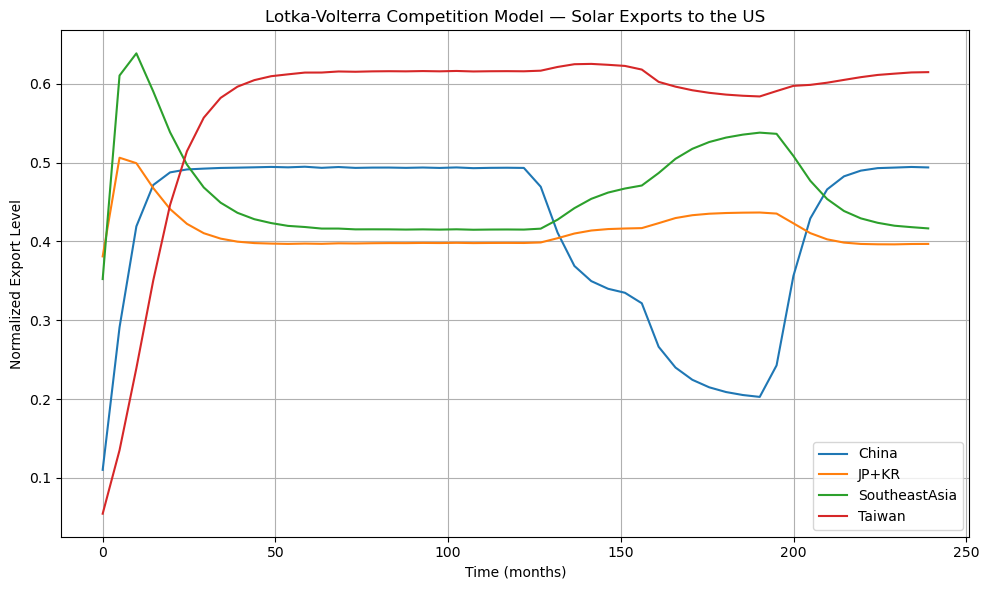

In [78]:
# Uncomment to use parameters for normalized values
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.35,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.5,
    'a41': 0.2, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0,
    'b12': 0.1, 'b13': 0.1, 'b14': 0.1, 
    'b21': 0.1, 'b23': 0.1, 'b24': 0.1,
    'b31': 0.1, 'b32': 0.1, 'b34': 0.1,
    'b41': 0.1, 'b42': 0.1, 'b43': 0.1
}

# # Uncomment to use parameters for absolute values
# params = {
#     'r1': 50.0, 'r2': 30.0, 'r3': 40.0, 'r4': 35.0,
#     'a11': 0.00001, 'a12': 0.000006, 'a13': 0.000004, 'a14': 0.000003,
#     'a21': 0.000004, 'a22': 0.000002, 'a23': 0.000003, 'a24': 0.000004,
#     'a31': 0.000004, 'a32': 0.000002, 'a33': 0.000003, 'a34': 0.000005,
#     'a41': 0.000006, 'a42': 0.000004, 'a43': 0.000004, 'a44': 0.00001,
#     'b1': 0.000001, 'b2': 0.000001, 'b3': 0.000001, 'b4': 0.000001
# }


# Initial conditions (example, adjust as needed)
X0 = df_normalized.iloc[0, 1:].values.tolist()  # Use the first row of normalized data as initial conditions

# Time span and evaluation points
t_span = (0, 239)
t_eval = np.linspace(*t_span)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='JP+KR')
plt.plot(sol.t, sol.y[2], label='SoutheastAsia')
plt.plot(sol.t, sol.y[3], label='Taiwan')
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.878e+00 ...  2.341e+02  2.390e+02]
        y: [[ 1.103e-01  2.910e-01 ...  4.944e-01  4.938e-01]
            [ 3.810e-01  5.061e-01 ...  3.967e-01  3.968e-01]
            [ 3.522e-01  6.103e-01 ...  4.181e-01  4.165e-01]
            [ 5.468e-02  1.351e-01 ...  6.143e-01  6.146e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 278
     njev: 0
      nlu: 0

### Model Calibration - Least Squares

In [80]:
china_data = df_normalized['China']
jpkr_data = df_normalized['JP+KR']
southeastasia_data = df_normalized['SoutheastAsia']
taiwan_data = df_normalized['Taiwan']

# Stack data for comparison
data = np.vstack([china_data, jpkr_data, southeastasia_data, taiwan_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [81]:
def residuals(params, X0, tariffs, t_data, data):
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:20]
    b12, b13, b14 = params[20:23]
    b21, b23, b24 = params[23:26]
    b31, b32, b34 = params[26:29]
    b41, b42, b43 = params[29:32]

    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_with_tariffs_end(
            t, X, tariffs, r1, r2, r3, r4,
            a11, a12, a13, a14,
            a21, a22, a23, a24,
            a31, a32, a33, a34,
            a41, a42, a43, a44,
            b12, b13, b14,
            b21, b23, b24,
            b31, b32, b34,
            b41, b42, b43
        ),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data
    )

    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    return (sol.y - data).ravel()

In [82]:
# Initial guess for 4 regions: r1, r2, r3, r4, a11, a12, a13, a14, ..., b44 (total 36 params)
initial_guess = [
    params['r1'], params['r2'], params['r3'], params['r4'],
    params['a11'], params['a12'], params['a13'], params['a14'],
    params['a21'], params['a22'], params['a23'], params['a24'],
    params['a31'], params['a32'], params['a33'], params['a34'],
    params['a41'], params['a42'], params['a43'], params['a44'],
    params['b12'], params['b13'], params['b14'],
    params['b21'], params['b23'], params['b24'],
    params['b31'], params['b32'], params['b34'],
    params['b41'], params['b42'], params['b43']
]

In [83]:
# Initial export levels from your data
X0 = data[:, 0]

# Fit the model
result = least_squares(residuals, initial_guess, args=(X0, df_tariffs, t_data, data), bounds=(0, np.inf))  # constrain params to be positive

# Extract best-fit parameters
fitted_params = result.x

In [84]:
fitted_params

array([0.32594264, 0.03920491, 0.23132607, 0.32677118, 1.10670049,
       0.20335001, 1.56953239, 0.50895293, 0.69817869, 1.37161446,
       1.16279552, 0.92489766, 1.11681665, 0.66049693, 1.27639334,
       0.60966551, 0.59342558, 0.49219406, 1.53353695, 1.65890996,
       0.07538439, 0.07537802, 0.06766138, 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.3078982 , 0.30789799])

In [85]:
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

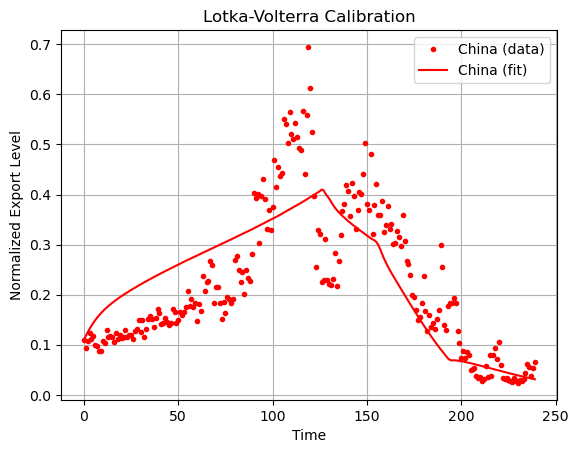

In [86]:
# Plot
plt.plot(t_data[:len(data[0])], data[0], 'r.', label='China (data)')
plt.plot(t_data, sol.y[0], 'r-', label='China (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

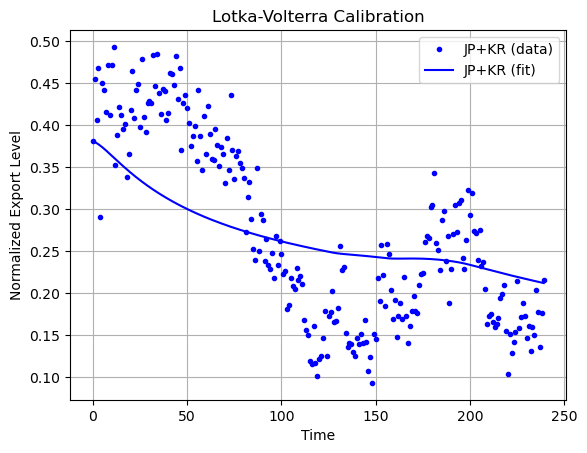

In [87]:
plt.plot(t_data[:len(data[1])], data[1], 'b.', label='JP+KR (data)')
plt.plot(t_data, sol.y[1], 'b-', label='JP+KR (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

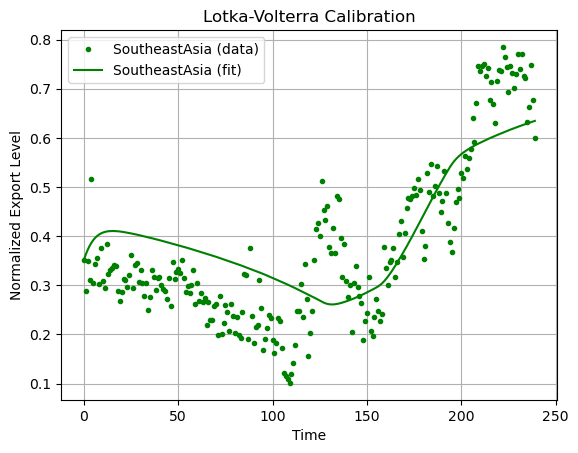

In [88]:
plt.plot(t_data[:len(data[2])], data[2], 'g.', label='SoutheastAsia (data)')
plt.plot(t_data, sol.y[2], 'g-', label='SoutheastAsia (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

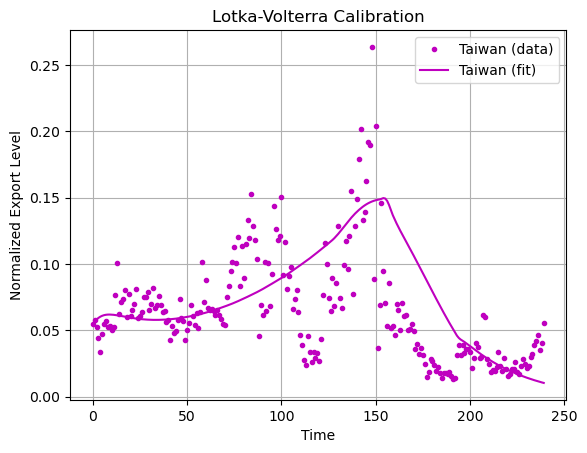

In [89]:
plt.plot(t_data[:len(data[3])], data[3], 'm.', label='Taiwan (data)')
plt.plot(t_data, sol.y[3], 'm-', label='Taiwan (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

### Prediction

In [ ]:
df_tariffs_pred = pd.concat([df_tariffs.copy(), pd.DataFrame(np.zeros([240, 4]), columns=['China Tariff', 'JP+KR Tariff', 'SoutheastAsia Tariff', 'Taiwan Tariff'])], axis=0)
df_tariffs_pred = df_tariffs_pred.reset_index(drop=True)
df_tariffs_pred['Time'] = pd.date_range(start='2002-01-01', periods=len(df_tariffs_pred), freq='MS')
df_tariffs_pred

,Time,China Tariff,JP+KR Tariff,SoutheastAsia Tariff,Taiwan Tariff
0,2002-01-01,0.0,0.0,0.0,0.0
1,2002-02-01,0.0,0.0,0.0,0.0
2,2002-03-01,0.0,0.0,0.0,0.0
3,2002-04-01,0.0,0.0,0.0,0.0
4,2002-05-01,0.0,0.0,0.0,0.0
...,...,...,...,...,...
475,2041-08-01,0.0,0.0,0.0,0.0
476,2041-09-01,0.0,0.0,0.0,0.0
477,2041-10-01,0.0,0.0,0.0,0.0
478,2041-11-01,0.0,0.0,0.0,0.0


In [ ]:
df_tariffs_pred['China Tariff'] = np.where(df_tariffs_pred['Time'] < '2026-05-01', 0, 1)
df_tariffs_pred['JP+KR Tariff'] = np.where(df_tariffs_pred['Time'] < '2028-02-01', 0, 1)
df_tariffs_pred['SoutheastAsia Tariff'] = np.where(df_tariffs_pred['Time'] < '2023-02-01', 0, 1)
df_tariffs_pred['Taiwan Tariff'] = np.where(df_tariffs_pred['Time'] < '2025-12-01', 0, 1)
df_tariffs_pred

,Time,China Tariff,JP+KR Tariff,SoutheastAsia Tariff,Taiwan Tariff
0,2002-01-01,0,0,0,0
1,2002-02-01,0,0,0,0
2,2002-03-01,0,0,0,0
3,2002-04-01,0,0,0,0
4,2002-05-01,0,0,0,0
...,...,...,...,...,...
475,2041-08-01,1,1,1,1
476,2041-09-01,1,1,1,1
477,2041-10-01,1,1,1,1
478,2041-11-01,1,1,1,1


In [ ]:
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs_pred, *fitted_params),
    t_span=(0, len(df_tariffs_pred) - 1),
    y0=X0,
    t_eval=np.arange(len(df_tariffs_pred))
)

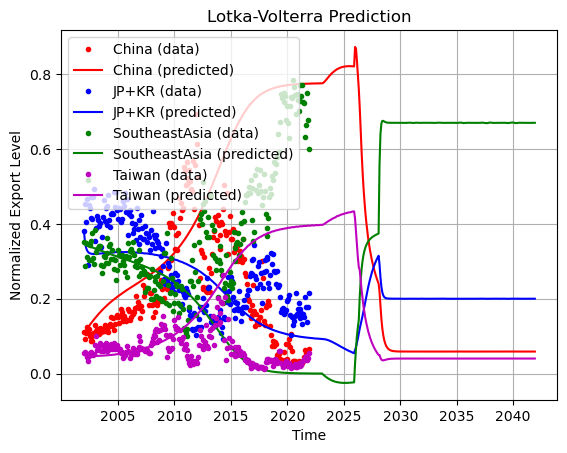

In [ ]:
# Plot
plt.plot(df_tariffs_pred['Time'][:len(data[0])], data[0], 'r.', label='China (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[0], 'r-', label='China (predicted)')
plt.plot(df_tariffs_pred['Time'][:len(data[1])], data[1], 'b.', label='JP+KR (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[1], 'b-', label='JP+KR (predicted)')
plt.plot(df_tariffs_pred['Time'][:len(data[2])], data[2], 'g.', label='SoutheastAsia (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[2], 'g-', label='SoutheastAsia (predicted)')
plt.plot(df_tariffs_pred['Time'][:len(data[3])], data[3], 'm.', label='Taiwan (data)')
plt.plot(df_tariffs_pred['Time'], sol.y[3], 'm-', label='Taiwan (predicted)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Prediction')
plt.grid(True)
plt.show()